# Baseline model for IMDB

In [1]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
from nltk import word_tokenize


from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader

from torch.nn.utils.rnn import pad_sequence

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ngtna\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
device =  torch.device("cuda" if torch.cuda.is_available() else "cpu")
device 

device(type='cuda')

## Load the dataframe and split it

In [3]:
filename = "IMDB Dataset.csv"
df = pd.read_csv(filename)

In [4]:
df.sample()

,review,sentiment
38863,What can you say when you see a good French mo...,positive


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [6]:
df["sentiment"].unique()

array(['positive', 'negative'], dtype=object)

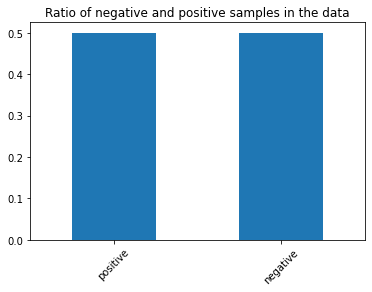

In [7]:
df["sentiment"].value_counts(normalize=True).plot.bar()
plt.xticks(rotation = 45)
plt.title("Ratio of negative and positive samples in the data")
plt.show()

In [8]:
df["target"] = df["sentiment"].apply(lambda x: 0 if x=="negative" else 1)

In [9]:
df = df.iloc[:100,:]

In [10]:
text_list = df["review"].to_list()
target_list = df[["target"]].to_numpy()
text_train, text_test, target_train, target_test = train_test_split(
   text_list, target_list, test_size=0.2, stratify=target_list)

## Dataset

In [44]:
class TextClassificationDataset(Dataset):
    def __init__(self, data, categories, vocab = None, max_length = 100, min_freq = 5):
        self.data = data      
        # Set the maximum length we will keep for the sequences
        self.max_length = max_length
        
        # Allow to import a vocabulary (for valid/test datasets, that will use the training vocabulary)
        if vocab is not None:
            self.word2idx, self.idx2word = vocab
        else:
            # If no vocabulary imported, build it (and reverse)
            self.word2idx, self.idx2word = self.build_vocab(self.data, min_freq)
        
        # We then need to tokenize the data .. 
        tokenized_data = [word_tokenize(elem) for elem in self.data] 
        # Transform words into lists of indexes ... (use the .get() method to redirect unknown words to the UNK token)
        indexed_data = []
        for token in tokenized_data:
            idx=[]
            for elem in token:
                if self.word2idx.get(elem)==None:
                    idx.append(self.word2idx.get('UNK'))
                else:
                    idx.append(self.word2idx.get(elem))
            indexed_data.append(idx)
        # And transform this list of lists into a list of Pytorch LongTensors
        tensor_data =[torch.LongTensor(elem) for elem in indexed_data] 
        tensor_y = torch.FloatTensor(categories)   
        cut_tensor_data =[elem[:max_length] for elem in tensor_data] 
        
        # Now, we need to use the pad_sequence function to have the whole dataset represented as one tensor,
        # containing sequences of the same length. We choose the padding_value to be 0, the we want the
        # batch dimension to be the first dimension 
        self.tensor_data = pad_sequence(cut_tensor_data, batch_first=True, padding_value=0)
        self.tensor_y = tensor_y
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        return self.tensor_data[idx], self.tensor_y[idx] 
    
    def build_vocab(self, corpus, count_threshold):
        """
        Same as in the previous TP: we want to output word_index, a dictionary containing words 
        and their corresponding indexes as {word : indexes} 
        But we also want the reverse, which is a dictionary {indexes: word}
        Don't forget to add a UNK token that we need when encountering unknown words
        We also choose '0' to represent the padding index, so begin the vocabulary index at 1 ! 
        """
        word_counts = {}
        # create list of all elements in corpus in corpus
        corp=[]
        for element in corpus:
            corp.append(word_tokenize(element))
        for text in corp:
            for word in text:
                word_counts[word.lower()]=word_counts.get(word.lower(),0)+text.count(word)
        keys=sorted(word_counts) #sort the words in alphabetical order 
        filtered_word_counts = {}
        for key in keys:
            if (word_counts[key]>=count_threshold): # retrieve words with occurences higher than count_threshold
                filtered_word_counts[key]=word_counts[key]
        word_index={}
        i=1
        for key in filtered_word_counts.keys():
            word_index[key]=i
            i+=1 
        word_index['UNK']=i  #adding UNK 
        idx_word={idx:word for word,idx in word_index.items()}
        return word_index, idx_word
    
    def get_vocab(self):
        # A simple way to get the training vocab when building the valid/test 
        return self.word2idx, self.idx2word

In [45]:
training_dataset = TextClassificationDataset(text_train, target_train)
training_word2idx, training_idx2word = training_dataset.get_vocab()

In [46]:
test_dataset = TextClassificationDataset(text_test, target_test, (training_word2idx, training_idx2word))
training_dataloader = DataLoader(training_dataset, batch_size = 32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size = 16)

## Model definition

In [90]:
class BaselineModel(nn.Module):
    def __init__(self, embedding_dim, vocabulary_size, hidden_dim, embeddings=None, fine_tuning=False):
        super(BaselineModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.embeddings = nn.Embedding(num_embeddings=vocabulary_size+1,embedding_dim=embedding_dim)
        self.lstm = nn.LSTM(input_size=embedding_dim,
                            hidden_size=hidden_dim,
                            batch_first=True,
                            bidirectional = False)
        self.linear = nn.Linear(in_features=hidden_dim, out_features=1)

    def forward(self, inputs):
        x = self.embeddings(inputs)
        ouput_lstm, (final_hidden_state, final_cell_state) = self.lstm(x) 
        # ouput_lstm_shape: (batch_size, sequence_length, hidden_dim_lstm)
        # final_hidden_state: (1, batch_size, hidden_dim_lstm)
        # final_cell_state: (1, batch_size, hidden_dim_lstm)
        # for lstm https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html     
        normal_final_hidden_state = torch.squeeze(final_hidden_state, dim=0) # remove dim first dimention 
        output_logit = self.linear(normal_final_hidden_state)
        return(output_logit)

In [91]:
model = BaselineModel(300, len(training_word2idx), 32).to(device)
opt = optim.Adam(model.parameters(), lr=0.0025, betas=(0.9, 0.999))
criterion = nn.BCEWithLogitsLoss()

## Train, val, experiment functions (helper functions)

In [92]:
def acc_metric_helper(y_logit, target, thresh=0.5):
        act = torch.sigmoid(y_logit)
        y_pred = (act>thresh).float()
        num_corrects = sum(y_pred==target)
        num_samples = len(target)
        return num_corrects, num_samples

In [93]:
def train_epoch(model, opt, criterion, dataloader):
    """
    Training model for one epoch
    
    Parameters
    ----------
    model : model will be trained
    opt : optimizer 
    criterion : for loss function
    dataloader : input of the model in the form of dataloader
    Returns
    -------
    list of all batch losses in this epoch
    """
    model.train()
    loss_epoch = 0.0
    acc_epoch = 0.0
    num_corrects_epoch = 0.0
    num_samples_epoch = 0.0
    for i, (x, y) in enumerate(dataloader):
        x= x.to(device)
        y= y.to(device)
        opt.zero_grad()
        y_logit = model.forward(x)
        loss = criterion(y_logit, y)
        loss.backward() 
        opt.step() 
        loss_epoch += loss.item()
        num_corrects, num_samples = acc_metric_helper(y_logit, y)
        num_corrects_epoch += num_corrects
        num_samples_epoch += num_samples 
    return loss_epoch, num_corrects_epoch/num_samples_epoch

In [94]:
def eval_model(model, criterion, evalloader):
    model.eval()
    total_epoch_loss = 0
    total_epoch_acc = 0
    with torch.no_grad():
        for i, (x, y) in enumerate(evalloader):
            x = x.to(device)
            y = y.to(device)
            pred = model.forward(x) 
            loss = criterion(pred, y)
            # get probability of the prediction 
            act = torch.sigmoid(pred)
            # act.to("cpu")                             
            thresh = 0.5
            postact = (act>0.5).float()
            num_corrects = sum(y==postact) 
            acc = 100.0 * num_corrects/len(y)
            total_epoch_loss += loss.item()
            total_epoch_acc += acc.item()

    return total_epoch_loss/(i+1), total_epoch_acc/(i+1)

In [95]:
def experiment(model, opt, criterion, num_epochs = 5, early_stopping = False):
    train_losses = []
    train_accs = []
    valid_losses = []
    valid_accs = []
    # if early_stopping: 
    #     best_valid_loss = 10. 
    print("Beginning training...")
    for e in range(num_epochs):
        print("Epoch " + str(e+1) + ":")
        train_loss, train_acc = train_epoch(model, opt, criterion, training_dataloader)  # Add all elements of a list to the previous list. extend
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        # For validation/test set
        valid_loss, valid_acc = eval_model(model, criterion, test_dataloader)
        valid_losses.append(valid_loss)
        valid_accs.append(valid_acc)
        print("Epoch " + str(e+1) + " : Training loss = " + str(train_loss) + "; Training acc = " + str(train_acc) + " : Validation loss = " + str(valid_loss) + "; Validation acc = " + str(valid_acc))
        # if early_stopping:
        #     if valid_loss < best_valid_loss:
        #         best_valid_loss = valid_loss
        #     else:
        #         print("Early stopping.")
        #         break  
    # test_loss, test_acc = eval_model(model, criterion, test_dataloader)
    # print("Epoch " + str(e+1) + " : Test loss = " + str(test_loss) + "; Test acc = " + str(test_acc))
    return train_losses, valid_losses

## Run and visualisation

In [96]:
train_losses, valid_losses = experiment(model, opt, criterion)

Beginning training...
Epoch 1:
Epoch 1 : Training loss = 2.2064362168312073; Training acc = tensor([0.3875], device='cuda:0') : Validation loss = 0.6673890054225922; Validation acc = 75.0
Epoch 2:
Epoch 2 : Training loss = 1.9033655524253845; Training acc = tensor([0.7875], device='cuda:0') : Validation loss = 0.6854460537433624; Validation acc = 62.5
Epoch 3:
Epoch 3 : Training loss = 1.785624623298645; Training acc = tensor([0.8000], device='cuda:0') : Validation loss = 0.7083310484886169; Validation acc = 53.125
Epoch 4:
Epoch 4 : Training loss = 1.6908665895462036; Training acc = tensor([0.8000], device='cuda:0') : Validation loss = 0.725695937871933; Validation acc = 53.125
Epoch 5:
Epoch 5 : Training loss = 1.5530616641044617; Training acc = tensor([0.8125], device='cuda:0') : Validation loss = 0.7408348321914673; Validation acc = 53.125


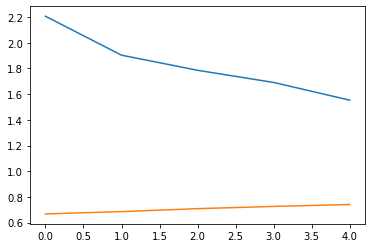

In [97]:
import matplotlib.pyplot as plt
plt.plot(train_losses)
plt.plot(valid_losses)